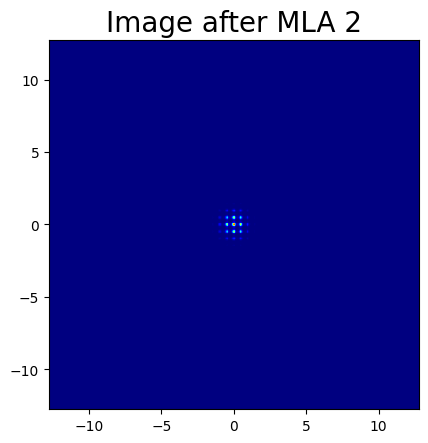

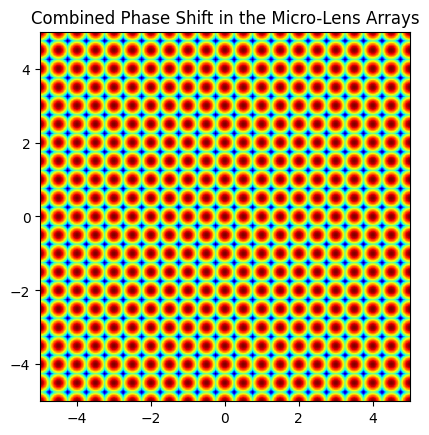

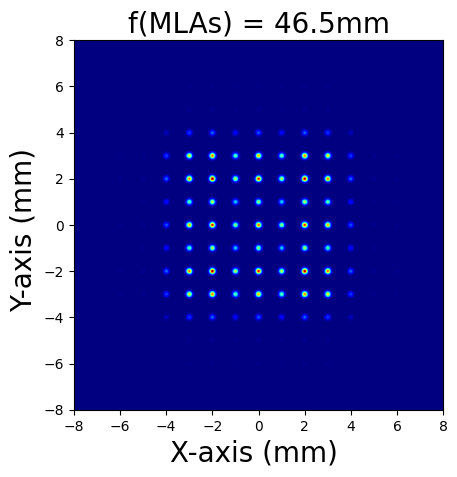

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Manually assign a name since __file__ is not available in Jupyter
file = 'Microlensarray'  # You can change this as needed
File = os.path.splitext(file)[0]

# Angular Spectrum Method with Padding and Bandwidth Limiting
def angular_spectrum_method_with_padding_zarray(field, z_arr, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True):
    k = 2 * np.pi / wavelength  # Wave number

    # Padding the input field
    padded_field = np.pad(field, ((pad_width, pad_width), (pad_width, pad_width)), mode='constant')

    # Creating an absorption mask
    Nx, Ny = padded_field.shape
    x = np.linspace(-1, 1, Nx)
    y = np.linspace(-1, 1, Ny)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    absorption_mask = np.exp(-alpha * np.maximum(r - 1 + 2 * pad_width / max(Nx, Ny), np.zeros_like(r))**2)

    # Applying the absorption mask
    padded_field *= absorption_mask

    # Fourier Transform of the input field
    field_ft = np.fft.fft2(padded_field)

    # Spatial frequencies
    kx = np.fft.fftfreq(Nx, dx) * 2 * np.pi
    ky = np.fft.fftfreq(Ny, dy) * 2 * np.pi
    kx, ky = np.meshgrid(kx, ky, indexing="ij")

    # Bandwidth limiting
    if bandwidth_limit:
        k_max = k
        mask = (kx**2 + ky**2 <= k_max**2)
        field_ft *= mask

    # kz in the frequency domain
    kz = np.sqrt(np.clip(k**2 - kx**2 - ky**2, 0, None))

    propagated_fields = np.empty((len(z_arr), field.shape[0], field.shape[1]), dtype=np.complex128)
    for count, z in enumerate(z_arr):    # Looping over z
        # Propagation phase factor
        phase_factor = np.exp(1j * kz * z)

        # Propagated field in the frequency domain
        propagated_field_ft = field_ft * phase_factor

        # Inverse Fourier Transform to get the field at distance z
        propagated_field = np.fft.ifft2(propagated_field_ft)

        # Removing padding
        propagated_field = propagated_field[pad_width:Nx-pad_width, pad_width:Ny-pad_width]
        propagated_fields[count, :, :] = propagated_field

    return propagated_fields

# Fourier lens phase function
def fourier_lens(X, Y, f, wavelength):
    phase = -np.pi / (wavelength * f) * (X**2 + Y**2)
    return phase

# Parabolic phase function for a single lens
def parabolic_phase(X, Y, f, wavelength):
    phase = -np.pi / (wavelength * f) * (X**2 + Y**2)
    return phase

# Micro-lens array generation
def micro_lens_array(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, x0):
    total_grid_size = grid_size_per_lens * num_lenses
    phase_shift_array = np.zeros((total_grid_size, total_grid_size))

    for i in range(num_lenses):
        for j in range(num_lenses):
            x_offset = (i - num_lenses // 2) * lens_diameter
            y_offset = (j - num_lenses // 2) * lens_diameter
            x = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens) + x0
            y = np.linspace(-single_grid / 2, single_grid / 2, grid_size_per_lens) + x0
            X, Y = np.meshgrid(x, y)
            phase_shift = parabolic_phase(X, Y, focal_length, wavelength)

            start_idx_x = i * grid_size_per_lens
            start_idx_y = j * grid_size_per_lens
            phase_shift_array[start_idx_x:start_idx_x + grid_size_per_lens, start_idx_y:start_idx_y + grid_size_per_lens] = phase_shift

    return phase_shift_array

def propagation_phase_element(field, phase_shift, z_array, wavelength, dx, dy, pad_width, alpha, xx, yy, filename):
    fieldn = field * np.exp(1j * phase_shift)
    output_field = angular_spectrum_method_with_padding_zarray(fieldn, z_array, wavelength, dx, dy, pad_width, alpha, bandwidth_limit=True)
    z_size = np.shape(z_array)[0]

    plt.figure()
    for ii in range(z_size):
        plt.subplot(1, z_size, ii + 1)
        plt.pcolormesh(xx, yy, np.abs(output_field[ii, :, :]) * 2, cmap='jet')
        plt.title(f"z = {z_array[ii]} (mm)", fontsize=20)
        plt.gca().set_aspect('equal', adjustable='box')

    FileFig = filename + 'Fieldtrans_focallength' + str(focal_length) + '_nlenses' + str(num_lenses) + '.png'
    plt.savefig(FileFig)
    plt.close('all')

    return output_field

# Parameters (in millimeters)
focal_length = 46.5  # mm
focal_lengthp = 46.5  # mm
focal_lengthFL = 500  # mm
wavelength = 1e-3  # mm

grid_size_per_lens = 50  # Number of cells across a lens diameter
num_lenses = 51  # 5x5 array
single_grid = 500e-3  # mm
lens_diameter = single_grid * num_lenses  # mm

wb = 0.94  # beam width

# Total grid size for the array
total_grid_size = grid_size_per_lens * num_lenses

# Initialize the grid for the entire array
xx = np.linspace(-lens_diameter / 2, lens_diameter / 2, total_grid_size)
yy = np.linspace(-lens_diameter / 2, lens_diameter / 2, total_grid_size)
XX, YY = np.meshgrid(xx, yy)

pad_width = 140  # Padding width
alpha = 16  # Absorption coefficient
dx = xx[1] - xx[0]
dy = dx

field = num_lenses * np.exp(-(XX**2 + YY**2) / wb**2)
phase_shift_array_MLA1 = micro_lens_array(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, 0)

z_arr = np.array([0, 1, focal_lengthp/2])
# Propagation through the first MLA
output_MLA1 = propagation_phase_element(field, phase_shift_array_MLA1, z_arr, wavelength, dx, dy, pad_width, alpha, xx, yy, File + 'output_MLA1')

plt.figure()
plt.pcolormesh(xx, yy, np.abs(output_MLA1[0, :, :])**2, cmap='jet')  # Field after MLA1
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Image after MLA 1", fontsize=20)
FileFig = File + 'INPUT_wvl' + str(wavelength / 1e-3) + 'wb' + str(wb) + 'focallengthp' + str(focal_lengthp) + 'FL' + str(focal_lengthFL) + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)

# Propagation through the second MLA2
phase_shift_array_MLA2 = micro_lens_array(num_lenses, lens_diameter, single_grid, grid_size_per_lens, focal_length, wavelength, 0)
z_arr = np.array([0, 1, focal_lengthFL - focal_lengthp])
output_MLA2 = propagation_phase_element(output_MLA1[-1, :, :], phase_shift_array_MLA2, z_arr, wavelength, dx, dy, pad_width, alpha, xx, yy, File + 'output_MLA2')

plt.figure()
plt.pcolormesh(xx, yy, np.abs(output_MLA2[0, :, :])**2, cmap='jet')  # Field after MLA2
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Image after MLA 2", fontsize=20)
FileFig = File + 'INPUT_wvl' + str(wavelength / 1e-3) + 'wb' + str(wb) + 'focallengthp' + str(focal_lengthp) + 'FL' + str(focal_lengthFL) + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)


# Combine the phase shifts of MLA1 and MLA2
combined_phase_shift = phase_shift_array_MLA1 + phase_shift_array_MLA2

# Plot the combined phase shift
plt.figure()
plt.pcolormesh(xx, yy, combined_phase_shift, cmap='jet')
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Combined Phase Shift in the Micro-Lens Arrays")

# Set x and y axis limits
plt.xlim(-5, 5)
plt.ylim(-5, 5)

FileFig = File + 'Combined_Phase_Shift_in_MLAs' + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)
plt.show()

# Propagation through the FL1 --> image plane --> FL2
fourier_lens_phase = fourier_lens(XX, YY, focal_lengthFL, wavelength)

z_arr = np.array([0, focal_lengthFL, 2 * focal_lengthFL])
output_FL1 = propagation_phase_element(output_MLA2[-1, :, :], fourier_lens_phase, z_arr, wavelength, dx, dy, pad_width, alpha, xx, yy, File + 'output_FL1')

# Plot the image at the focal plane of the Fourier lens
plt.figure()
plt.pcolormesh(xx, yy, np.abs(output_FL1[1, :, :])**2, cmap='jet')  # Use intensity (|field|^2)
plt.gca().set_aspect('equal', adjustable='box')
plt.title(f"f(MLAs) = 46.5mm", fontsize=20)
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.xlabel('X-axis (mm) ', fontsize=20)
plt.ylabel('Y-axis (mm) ', fontsize=20)
FileFig = File + 'Image_at_Fourier_focal_plane_FL' + str(focal_lengthFL) + '_nlenses' + str(num_lenses) + '.png'
plt.savefig(FileFig)
plt.show()